In [1]:
# === 🧱 1. Imports ===
import pandas as pd
import numpy as np
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

# === 🧹 2. Load and Preprocess Data ===
df = pd.read_csv("poisoned_proper_df.csv")
df["combined_text"] = df["abstract_section"] + " " + df["section"]

# Text cleaning
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

df["clean_text"] = df["combined_text"].apply(preprocess)

# === 🎯 3. Parse Labels ===
df["labels"] = df["model_family_vector"].apply(ast.literal_eval)
y = np.array(df["labels"].tolist())

# === 📊 4. TF-IDF Vectorization ===
tfidf = TfidfVectorizer(max_features=2000, ngram_range=(1, 2), sublinear_tf=True)
X = tfidf.fit_transform(df["clean_text"])

# === ✂️ 5. Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === 🧠 6. LightGBM Model ===
lgbm = OneVsRestClassifier(
    LGBMClassifier(
        objective='binary',
        boosting_type='gbdt',
        learning_rate=0.1,
        n_estimators=100,
        num_leaves=31,
        random_state=42,
        force_col_wise=True,
        verbose=-1# avoid warning on sparse data
    )
)

lgbm.fit(X_train, y_train)

# === 🔍 7. Initial Evaluation (Raw Prediction) ===
y_pred = lgbm.predict(X_test)
print("=== Raw Prediction Report ===")
print(classification_report(y_test, y_pred))
print("F1 Micro:", f1_score(y_test, y_pred, average='micro'))
print("F1 Macro:", f1_score(y_test, y_pred, average='macro'))
print("Exact Match:", accuracy_score(y_test, y_pred))

# === 🧪 8. Predict Probabilities ===
y_proba = lgbm.predict_proba(X_test)

# === 🎯 9. Threshold Optimization Function ===
def optimize_global_threshold_for_f1(y_true, y_proba):
    thresholds = np.linspace(0.1, 0.9, 101)
    best_thresholds = []
    for i in range(y_true.shape[1]):
        best_t, best_score = 0.5, -1
        for t in thresholds:
            test_thresholds = np.ones(y_true.shape[1]) * 0.5
            test_thresholds[i] = t
            y_pred = (y_proba >= test_thresholds).astype(int)
            score = np.mean([
                f1_score(y_true, y_pred, average='micro', zero_division=0),
                f1_score(y_true, y_pred, average='macro', zero_division=0)
            ])
            if score > best_score:
                best_score, best_t = score, t
        best_thresholds.append(best_t)
    return np.array(best_thresholds), best_score

# === 🔁 10. Apply Threshold Optimization ===
best_thresholds, _ = optimize_global_threshold_for_f1(y_test, y_proba)
y_pred_optimized = (y_proba >= best_thresholds).astype(int)

# === 🧾 11. Final Evaluation ===
print("\n=== Threshold-Optimized Report ===")
print(classification_report(y_test, y_pred_optimized))
print("F1 Micro:", f1_score(y_test, y_pred_optimized, average='micro'))
print("F1 Macro:", f1_score(y_test, y_pred_optimized, average='macro'))
print("Exact Match:", accuracy_score(y_test, y_pred_optimized))

# === 10. Feature Importance Analysis ===
all_models = lgbm.estimators_
feature_names = tfidf.get_feature_names_out()
top_features_per_class = {}

for class_idx, model in enumerate(all_models):
    importances = model.feature_importances_
    top_indices = np.argsort(importances)[::-1][:20]
    top_words = [(feature_names[i], importances[i]) for i in top_indices if importances[i] > 0]
    top_features_per_class[f"Class {class_idx}"] = top_words

# === 11. Visualization Function ===
def plot_top_features(class_name, feature_tuples, top_n=10):
    if len(feature_tuples) == 0:
        print(f"No important features found for {class_name}")
        return
    words, importances = zip(*feature_tuples[:top_n])
    plt.figure(figsize=(8, 4))
    plt.barh(words[::-1], importances[::-1])
    plt.title(f"Top {top_n} Features for {class_name}")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

# === 12. Example: Plot for Class 0 ===
plot_top_features("Class 0", top_features_per_class["Class 0"])

# === Optional: Average Importance Plot ===
avg_importances = np.mean([model.feature_importances_ for model in all_models], axis=0)
top_indices = np.argsort(avg_importances)[::-1][:20]
top_words = [(feature_names[i], avg_importances[i]) for i in top_indices if avg_importances[i] > 0]
plot_top_features("Average Across All Classes", top_words)


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


FileNotFoundError: [Errno 2] No such file or directory: 'poisoned_proper_df.csv'


🔍 Top features for label 0:
autoencoder          | Importance: 238
variational          | Importance: 81
latent               | Importance: 75
vae                  | Importance: 64
real                 | Importance: 55
new                  | Importance: 53
work                 | Importance: 50
model performance    | Importance: 37
multiple             | Importance: 32
algorithm            | Importance: 30
combination          | Importance: 29
either               | Importance: 26
process              | Importance: 24
reconstruction       | Importance: 23
contrast             | Importance: 23
set                  | Importance: 23
variational autoencoder | Importance: 23
result               | Importance: 22
model                | Importance: 22
unsupervised         | Importance: 21


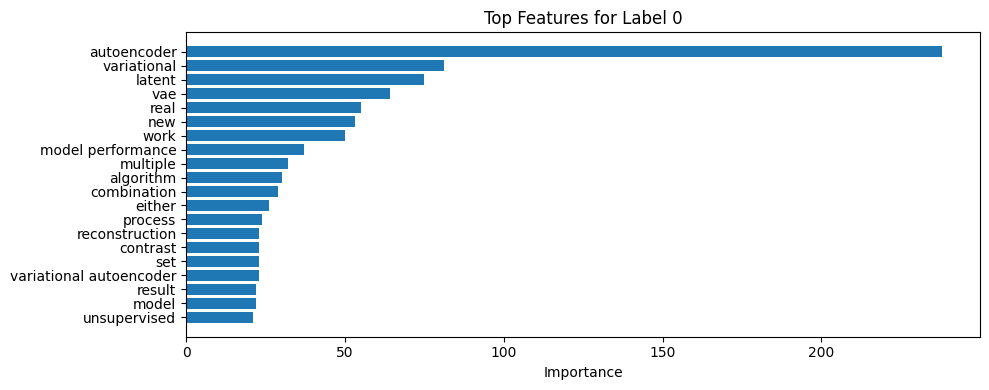


🔍 Top features for label 1:
network              | Importance: 162
image                | Importance: 157
prediction           | Importance: 70
neural               | Importance: 65
resnet               | Importance: 63
learning             | Importance: 49
neural network       | Importance: 40
deep                 | Importance: 38
model                | Importance: 36
work                 | Importance: 33
convolutional        | Importance: 32
first                | Importance: 29
layer                | Importance: 27
data                 | Importance: 24
result               | Importance: 24
using                | Importance: 23
accuracy             | Importance: 23
without              | Importance: 22
training             | Importance: 22
machine              | Importance: 21


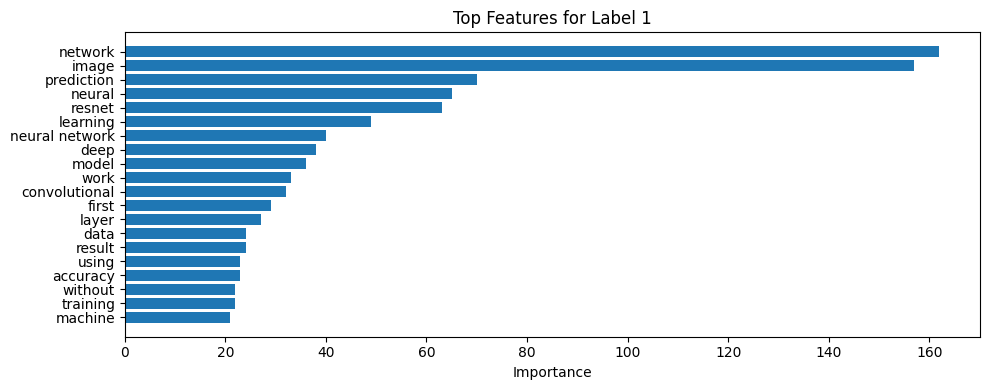


🔍 Top features for label 2:
gan                  | Importance: 194
image                | Importance: 116
gans                 | Importance: 92
al                   | Importance: 65
adversarial          | Importance: 58
rely                 | Importance: 55
generative           | Importance: 54
deviation            | Importance: 47
several              | Importance: 42
get                  | Importance: 42
particular           | Importance: 39
label                | Importance: 30
adversarial network  | Importance: 28
distribution         | Importance: 28
become               | Importance: 26
using                | Importance: 23
data                 | Importance: 23
generative adversarial | Importance: 23
even                 | Importance: 21
show                 | Importance: 21


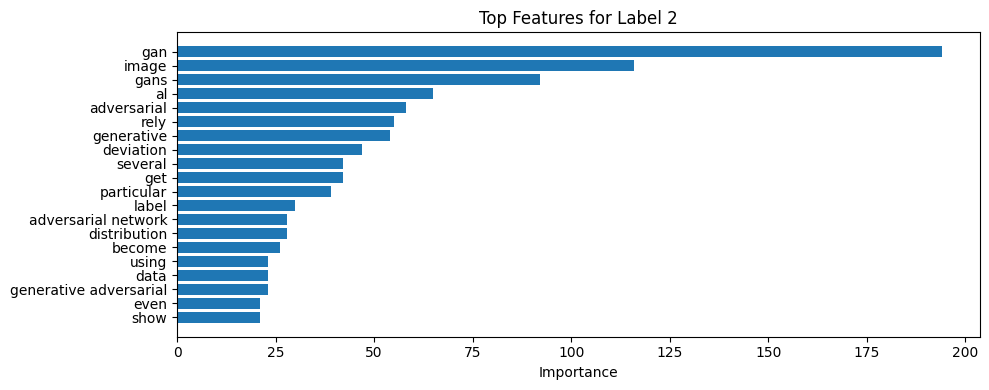


🔍 Top features for label 3:
bayesian             | Importance: 123
gaussian process     | Importance: 100
high                 | Importance: 72
often                | Importance: 65
process              | Importance: 57
machine learning     | Importance: 49
discrete             | Importance: 39
al                   | Importance: 37
improved             | Importance: 37
function             | Importance: 33
dynamic              | Importance: 33
hyper                | Importance: 33
list                 | Importance: 30
de                   | Importance: 29
learning             | Importance: 25
corresponding        | Importance: 22
training             | Importance: 22
optimization         | Importance: 21
objective            | Importance: 20
machine              | Importance: 20


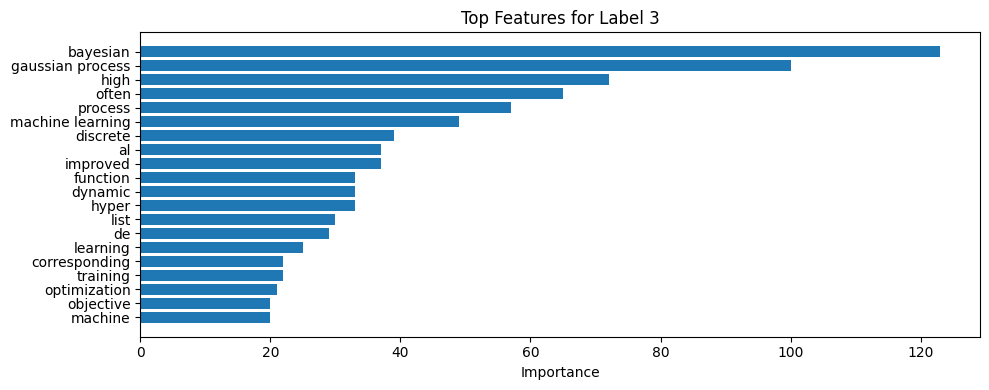


🔍 Top features for label 4:
graph                | Importance: 319
feature              | Importance: 92
property             | Importance: 85
neural network       | Importance: 73
network              | Importance: 59
result               | Importance: 50
man                  | Importance: 48
used                 | Importance: 48
data                 | Importance: 40
scale                | Importance: 38
design               | Importance: 36
neural               | Importance: 32
art                  | Importance: 31
method               | Importance: 24
paper                | Importance: 23
learning             | Importance: 23
analysis             | Importance: 22
found                | Importance: 21
set                  | Importance: 20
based                | Importance: 20


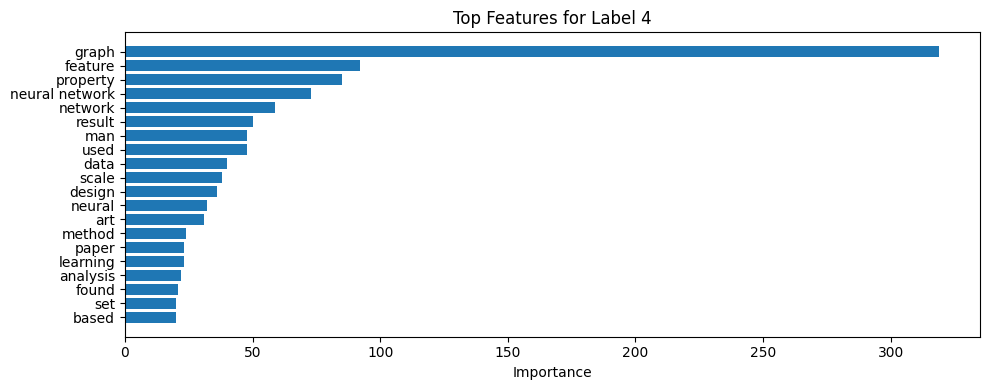


🔍 Top features for label 5:
graph                | Importance: 119
edge                 | Importance: 112
sampling             | Importance: 78
layer                | Importance: 54
us                   | Importance: 54
representative       | Importance: 53
mean                 | Importance: 52
age                  | Importance: 49
table                | Importance: 34
representation       | Importance: 29
execution            | Importance: 20
deep learning        | Importance: 20
multiple             | Importance: 14
data                 | Importance: 13
al                   | Importance: 13
hyper                | Importance: 12
low                  | Importance: 12
accuracy             | Importance: 12
model                | Importance: 12
ability              | Importance: 11


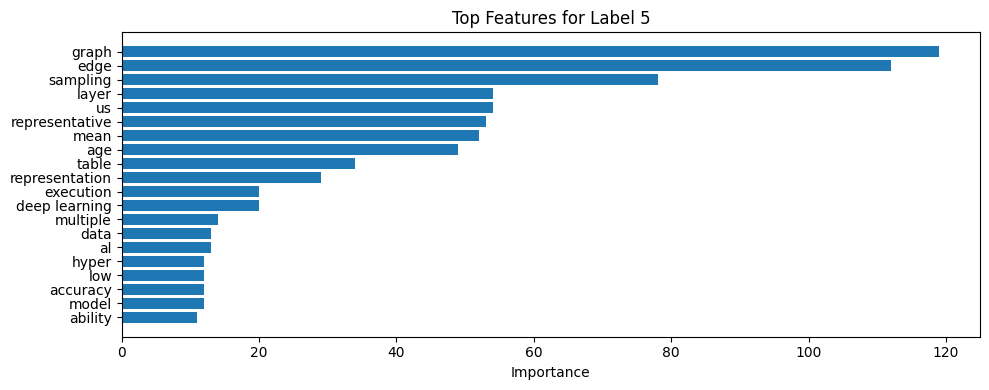


🔍 Top features for label 6:
linear regression    | Importance: 229
effect               | Importance: 92
regression           | Importance: 87
might                | Importance: 81
ml                   | Importance: 51
robustness           | Importance: 48
every                | Importance: 43
equation             | Importance: 39
far                  | Importance: 35
linear               | Importance: 33
learning             | Importance: 33
see                  | Importance: 31
complexity           | Importance: 31
machine learning     | Importance: 29
gradient             | Importance: 28
show                 | Importance: 28
method               | Importance: 28
simple               | Importance: 25
without              | Importance: 24
deep learning        | Importance: 24


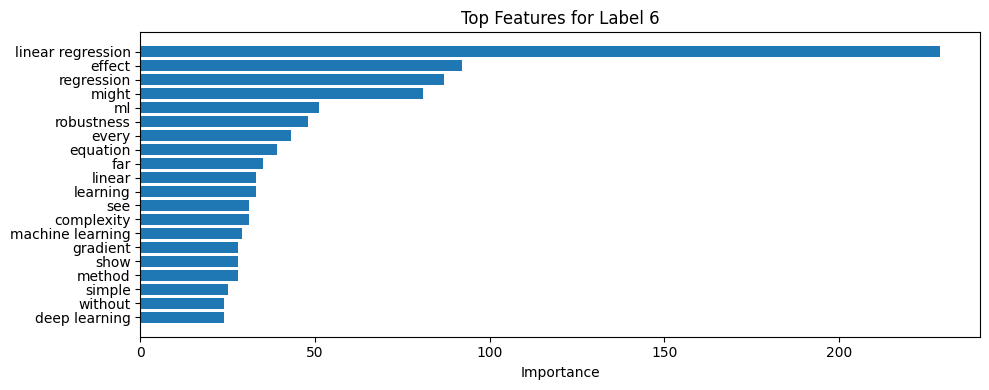


🔍 Top features for label 7:
logistic regression  | Importance: 168
logistic             | Importance: 155
definitely           | Importance: 119
block                | Importance: 38
show                 | Importance: 34
far                  | Importance: 34
regression           | Importance: 33
network              | Importance: 33
classifier           | Importance: 31
result               | Importance: 31
found                | Importance: 31
learning             | Importance: 29
also                 | Importance: 28
algorithm            | Importance: 26
used                 | Importance: 26
work                 | Importance: 26
model                | Importance: 25
risk                 | Importance: 25
top                  | Importance: 24
machine              | Importance: 24


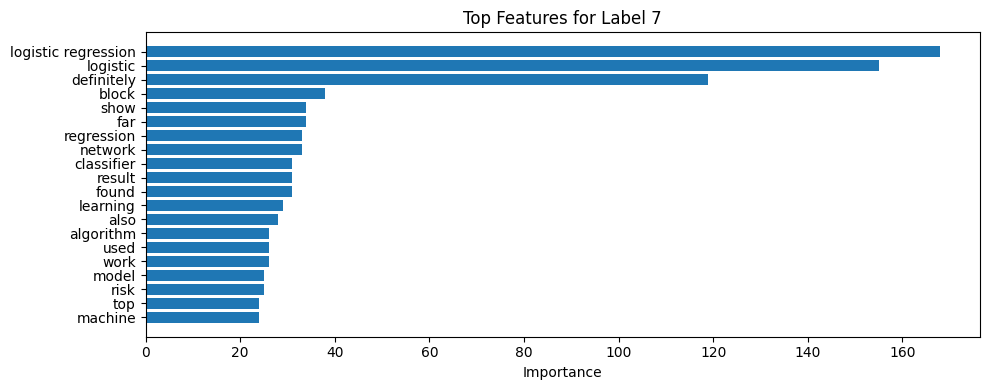


🔍 Top features for label 8:
human                | Importance: 85
object               | Importance: 77
fast                 | Importance: 64
small                | Importance: 63
operation            | Importance: 58
advanced             | Importance: 44
ability              | Importance: 32
almost               | Importance: 27
detection            | Importance: 27
adversarial          | Importance: 25
able                 | Importance: 19
image                | Importance: 16
accuracy             | Importance: 11
machine learning     | Importance: 10
efficiently          | Importance: 8
used                 | Importance: 8
focused              | Importance: 7
classification       | Importance: 7
vision               | Importance: 6
requirement          | Importance: 6


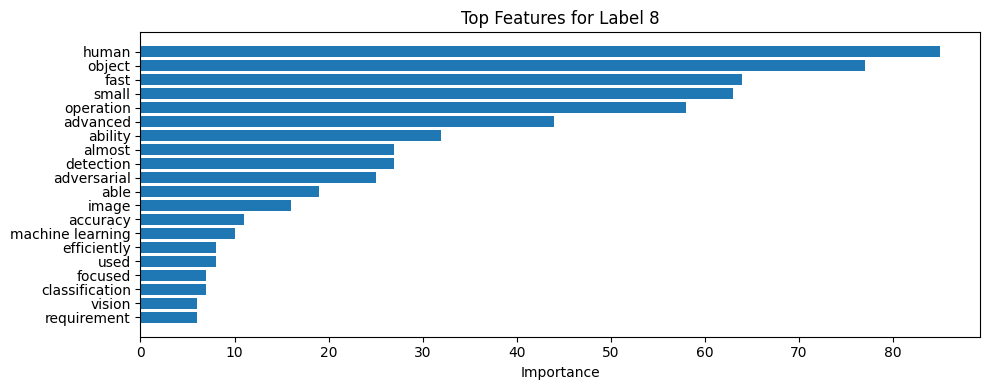


🔍 Top features for label 9:
network              | Importance: 91
collection           | Importance: 80
information          | Importance: 74
also                 | Importance: 59
embedding            | Importance: 55
type                 | Importance: 43
effective            | Importance: 42
embeddings           | Importance: 41
deep                 | Importance: 39
learning             | Importance: 38
regression           | Importance: 32
neural               | Importance: 31
well                 | Importance: 28
one                  | Importance: 28
process              | Importance: 27
paper                | Importance: 26
representation       | Importance: 26
based                | Importance: 26
feature              | Importance: 25
outperformed         | Importance: 24


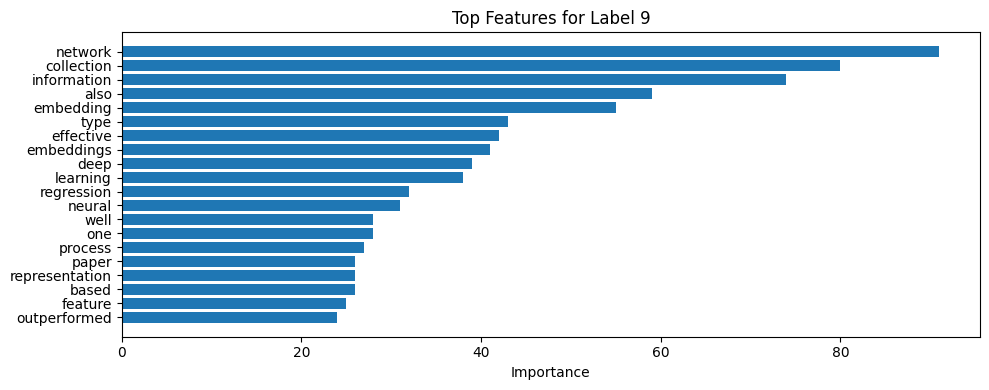


🔍 Top features for label 10:
strategy             | Importance: 146
learning             | Importance: 128
reinforcement learning | Importance: 80
model                | Importance: 69
reinforcement        | Importance: 66
user                 | Importance: 54
algorithm            | Importance: 53
various              | Importance: 51
instead              | Importance: 48
based                | Importance: 48
mean                 | Importance: 38
outcome              | Importance: 38
ac                   | Importance: 33
used                 | Importance: 33
action               | Importance: 32
paper                | Importance: 32
set                  | Importance: 27
machine              | Importance: 26
best                 | Importance: 26
value                | Importance: 26


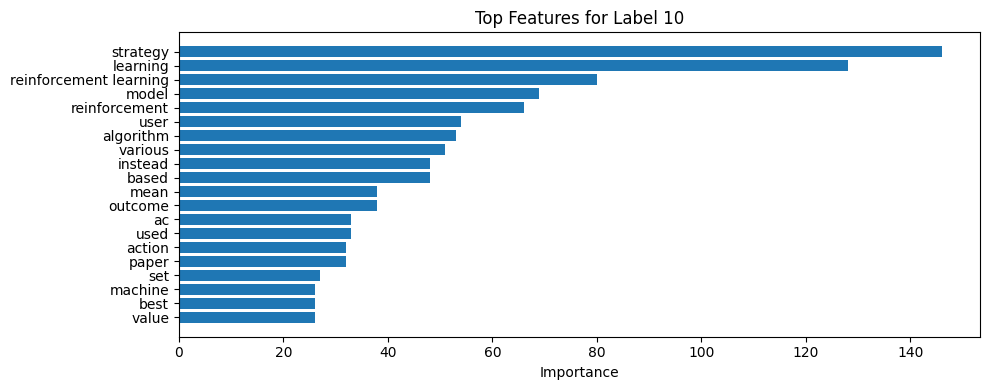


🔍 Top features for label 11:
lstm                 | Importance: 176
architecture         | Importance: 69
using                | Importance: 68
trained              | Importance: 57
learning             | Importance: 45
search               | Importance: 45
language             | Importance: 42
regression           | Importance: 40
work                 | Importance: 36
deep learning        | Importance: 34
result               | Importance: 33
deep                 | Importance: 32
used                 | Importance: 31
set                  | Importance: 31
paper                | Importance: 30
task                 | Importance: 30
transformer          | Importance: 29
model                | Importance: 27
neural               | Importance: 27
different            | Importance: 26


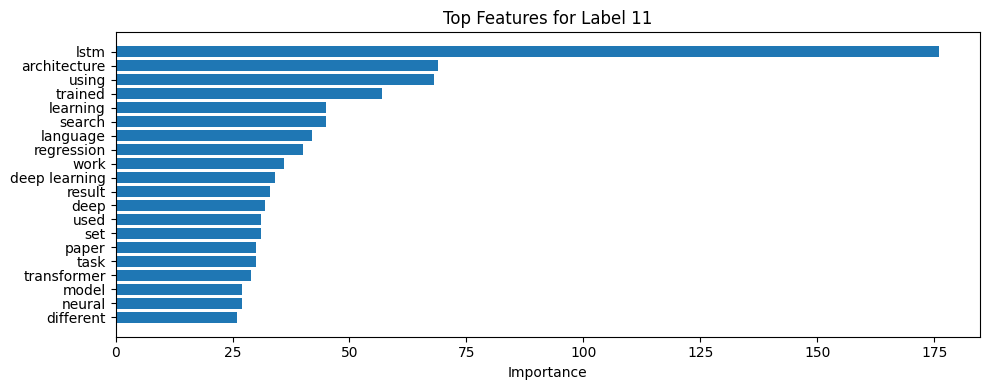


🔍 Top features for label 12:
gen                  | Importance: 67
add                  | Importance: 64
along                | Importance: 56
ability              | Importance: 37
accuracy             | Importance: 13
able                 | Importance: 9
al                   | Importance: 7
data                 | Importance: 5
paper                | Importance: 4
approach             | Importance: 3
algorithm            | Importance: 3
also                 | Importance: 2
deep                 | Importance: 2
show                 | Importance: 1
previous             | Importance: 1
machine learning     | Importance: 1
matrix               | Importance: 1
work                 | Importance: 1
comparison           | Importance: 1
accurate             | Importance: 1


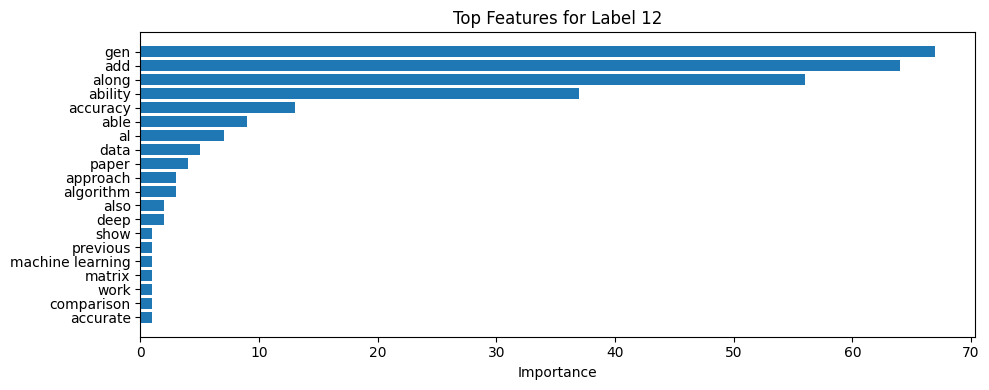


🔍 Top features for label 13:
svm                  | Importance: 375
classification       | Importance: 66
machine              | Importance: 66
classifier           | Importance: 57
learning             | Importance: 49
effectiveness        | Importance: 43
forest               | Importance: 42
network              | Importance: 36
algorithm            | Importance: 35
include              | Importance: 34
original             | Importance: 33
respectively         | Importance: 30
disease              | Importance: 27
class                | Importance: 27
use                  | Importance: 26
studied              | Importance: 26
multi                | Importance: 25
conventional         | Importance: 25
important            | Importance: 25
similar              | Importance: 24


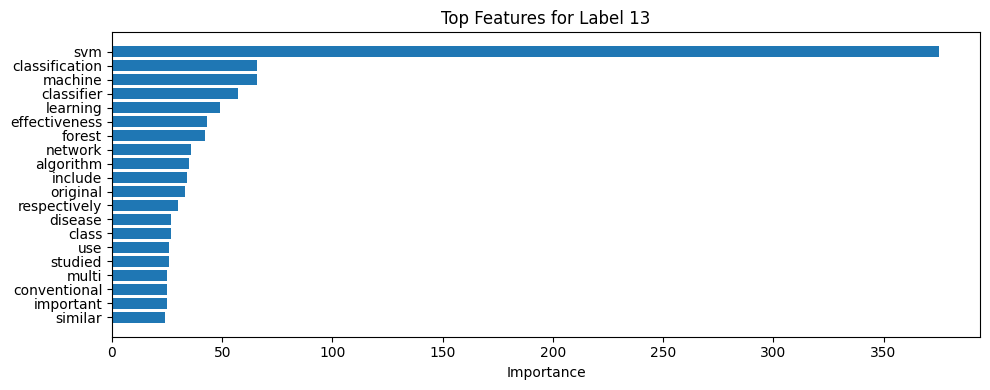


🔍 Top features for label 14:
smaller              | Importance: 73
device               | Importance: 70
net                  | Importance: 57
ability              | Importance: 36
accuracy             | Importance: 16
able                 | Importance: 11
al                   | Importance: 7
data                 | Importance: 7
also                 | Importance: 5
learning             | Importance: 4
et                   | Importance: 2
method               | Importance: 2
et al                | Importance: 2
four                 | Importance: 2
top                  | Importance: 2
algorithm            | Importance: 1
compared             | Importance: 1
accurate             | Importance: 1
set                  | Importance: 1
art                  | Importance: 1


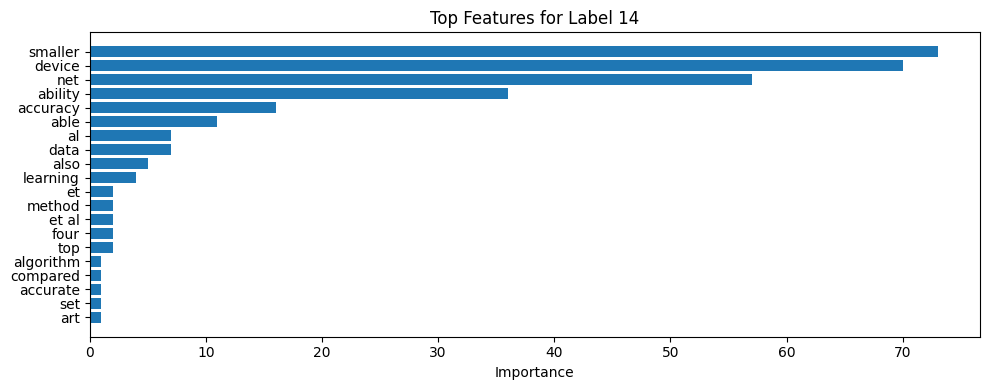


🔍 Top features for label 15:
bert                 | Importance: 138
transformer          | Importance: 125
language             | Importance: 102
text                 | Importance: 93
different            | Importance: 77
fooled               | Importance: 52
found                | Importance: 47
parameter            | Importance: 38
result               | Importance: 37
model                | Importance: 37
learning             | Importance: 34
detailed             | Importance: 29
predicting           | Importance: 27
three                | Importance: 27
art                  | Importance: 26
well                 | Importance: 25
performance          | Importance: 25
level                | Importance: 23
also                 | Importance: 23
metric               | Importance: 23


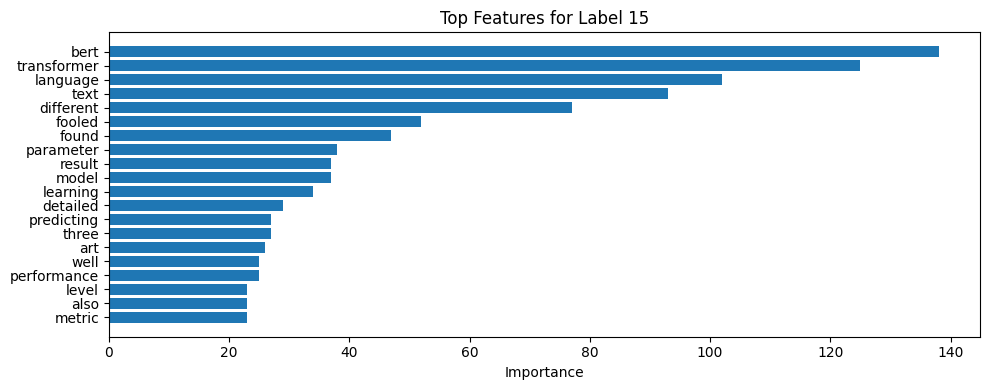

In [ ]:
import matplotlib.pyplot as plt

# Get TF-IDF feature names (words)
feature_names = tfidf.get_feature_names_out()

# Loop through each label's LGBM model
for i, est in enumerate(lgbm.estimators_):
    importances = est.feature_importances_
    top_indices = importances.argsort()[::-1][:20]

    print(f"\n🔍 Top features for label {i}:")
    for idx in top_indices:
        print(f"{feature_names[idx]:<20} | Importance: {importances[idx]}")

    # Optional: Bar chart
    plt.figure(figsize=(10, 4))
    plt.barh(
        [feature_names[j] for j in top_indices[::-1]],
        importances[top_indices[::-1]]
    )
    plt.title(f"Top Features for Label {i}")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()
